# Infinite Map Generation Testing
## Using OpenRouter GPT-5 Image Mini for Inpainting/Outpainting

This notebook tests generating infinite 2D RPG maps using inpainting and outpainting techniques.

In [3]:
# Install required packages
!pip install requests pillow numpy matplotlib ipython python-dotenv

In [4]:
import requests
import json
import base64
from PIL import Image, ImageDraw
import io
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import os

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
# Configuration
OPENROUTER_API_KEY = os.getenv('OPENROUTER_API_KEY', 'YOUR_API_KEY_HERE')
API_URL = "https://openrouter.ai/api/v1/chat/completions"

# Model to use
MODEL = "google/gemini-2.5-flash-image"

# Tile generation settings
TILE_ASPECT_RATIO = "1:1"  # Always square
OVERLAP_FRACTION = 0.1  # Default 10% overlap (one-tenth)

print(f"Model: {MODEL}")
print(f"Tile aspect ratio: {TILE_ASPECT_RATIO}")
print(f"Overlap fraction: {OVERLAP_FRACTION} ({int(OVERLAP_FRACTION * 100)}%)")
print(f"API Key configured: {'Yes' if OPENROUTER_API_KEY and OPENROUTER_API_KEY != 'YOUR_API_KEY_HERE' else 'No'}")

Model: google/gemini-2.5-flash-image
Tile aspect ratio: 1:1
Overlap fraction: 0.1 (10%)
API Key configured: Yes


## Utility Functions

In [6]:
def encode_image(image_path_or_pil):
    """Encode an image to base64 data URL"""
    if isinstance(image_path_or_pil, str):
        with open(image_path_or_pil, "rb") as f:
            image_data = f.read()
    else:
        # PIL Image
        buffer = io.BytesIO()
        image_path_or_pil.save(buffer, format="PNG")
        image_data = buffer.getvalue()
    
    base64_image = base64.b64encode(image_data).decode('utf-8')
    return f"data:image/png;base64,{base64_image}"

def decode_image(base64_string):
    """Decode a base64 image to PIL Image"""
    if base64_string.startswith('data:image'):
        base64_string = base64_string.split(',')[1]
    image_data = base64.b64decode(base64_string)
    return Image.open(io.BytesIO(image_data))

def save_image(base64_string, filepath):
    """Save a base64 encoded image to file"""
    img = decode_image(base64_string)
    img.save(filepath)
    print(f"Saved image to {filepath}")
    return img

def display_images(images, titles=None, figsize=(15, 5)):
    """Display multiple images side by side"""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    
    for i, (ax, img) in enumerate(zip(axes, images)):
        if isinstance(img, str):
            img = decode_image(img)
        ax.imshow(img)
        ax.axis('off')
        if titles and i < len(titles):
            ax.set_title(titles[i])
    
    plt.tight_layout()
    plt.show()

## Mask Creation Utilities

In [7]:
def create_overlap_outpainting_setup(original_img, direction='bottom', overlap_fraction=0.1):
    """Create proper overlap-based outpainting setup for square tiles
    
    Args:
        original_img: PIL Image - the original square tile
        direction: 'bottom', 'top', 'right', or 'left'
        overlap_fraction: Fraction of the image to use as overlap (e.g., 0.1 = 10% = one-tenth)
    
    Returns:
        (new_canvas, overlap_slice) tuple
        - new_canvas: Square canvas with overlap region + white space
        - overlap_slice: The extracted overlap region (for visualization)
    """
    width, height = original_img.size
    
    # For square tiles, overlap is same in both dimensions
    overlap_size = int(width * overlap_fraction)
    
    if direction == 'bottom':
        # Extract bottom edge of original (e.g., bottom 10%)
        overlap_slice = original_img.crop((0, height - overlap_size, width, height))
        
        # Create new square canvas (same size as original)
        new_canvas = Image.new('RGB', (width, height), (255, 255, 255))
        
        # Paste overlap at TOP edge
        new_canvas.paste(overlap_slice, (0, 0))
        
    elif direction == 'top':
        # Extract top edge of original
        overlap_slice = original_img.crop((0, 0, width, overlap_size))
        
        # Create new square canvas
        new_canvas = Image.new('RGB', (width, height), (255, 255, 255))
        
        # Paste overlap at BOTTOM edge
        new_canvas.paste(overlap_slice, (0, height - overlap_size))
        
    elif direction == 'right':
        # Extract right edge of original
        overlap_slice = original_img.crop((width - overlap_size, 0, width, height))
        
        # Create new square canvas
        new_canvas = Image.new('RGB', (width, height), (255, 255, 255))
        
        # Paste overlap at LEFT edge
        new_canvas.paste(overlap_slice, (0, 0))
        
    elif direction == 'left':
        # Extract left edge of original
        overlap_slice = original_img.crop((0, 0, overlap_size, height))
        
        # Create new square canvas
        new_canvas = Image.new('RGB', (width, height), (255, 255, 255))
        
        # Paste overlap at RIGHT edge
        new_canvas.paste(overlap_slice, (width - overlap_size, 0))
    
    return new_canvas, overlap_slice


def outpaint_square_tile(original_img, direction='bottom', content_description="", 
                         model=MODEL, overlap_fraction=OVERLAP_FRACTION):
    """Outpaint a square tile in a specific direction using conversational prompting
    
    This creates a new square tile that can be placed adjacent to the original.
    
    Args:
        original_img: PIL Image - the original square tile
        direction: 'bottom', 'top', 'right', or 'left'
        content_description: Additional content description for the new tile
        model: Which model to use
        overlap_fraction: Fraction of overlap (default 0.1 = 10%)
    
    Returns:
        Generated square tile (base64 data URL) or None
    """
    
    # Create the overlap setup
    new_canvas, overlap_slice = create_overlap_outpainting_setup(
        original_img, direction, overlap_fraction
    )
    
    width, height = new_canvas.size
    overlap_percent = int(overlap_fraction * 100)
    
    # Encode the partial image
    partial_image_data_url = encode_image(new_canvas)
    
    # Create direction-specific conversational prompt
    direction_prompts = {
        'bottom': f"""You are looking at a **partial square game map tile**. 

The **top {overlap_percent}%** of this image shows existing game content that must be preserved exactly.
The remaining **{100-overlap_percent}%** (the white area below) needs to be filled in.

**Task:** Continue and extend the map content DOWNWARD into the white area. The transition from the existing content must be **seamless** - the generated portion should look like a natural continuation of what's above.

{content_description}

**Remember:**
- This is ONE square tile that will be placed BELOW the original tile
- Keep all the technical specs and style rules from the original
- The top edge must blend perfectly with the existing content
- Fill the ENTIRE white area - no borders or margins""",
        
        'top': f"""You are looking at a **partial square game map tile**.

The **bottom {overlap_percent}%** of this image shows existing game content that must be preserved exactly.
The remaining **{100-overlap_percent}%** (the white area above) needs to be filled in.

**Task:** Continue and extend the map content UPWARD into the white area. The transition from the existing content must be **seamless**.

{content_description}

**Remember:**
- This is ONE square tile that will be placed ABOVE the original tile
- Keep all the technical specs and style rules from the original
- The bottom edge must blend perfectly with the existing content
- Fill the ENTIRE white area - no borders or margins""",
        
        'right': f"""You are looking at a **partial square game map tile**.

The **left {overlap_percent}%** of this image shows existing game content that must be preserved exactly.
The remaining **{100-overlap_percent}%** (the white area to the right) needs to be filled in.

**Task:** Continue and extend the map content to the RIGHT into the white area. The transition from the existing content must be **seamless**.

{content_description}

**Remember:**
- This is ONE square tile that will be placed to the RIGHT of the original tile
- Keep all the technical specs and style rules from the original
- The left edge must blend perfectly with the existing content
- Fill the ENTIRE white area - no borders or margins""",
        
        'left': f"""You are looking at a **partial square game map tile**.

The **right {overlap_percent}%** of this image shows existing game content that must be preserved exactly.
The remaining **{100-overlap_percent}%** (the white area to the left) needs to be filled in.

**Task:** Continue and extend the map content to the LEFT into the white area. The transition from the existing content must be **seamless**.

{content_description}

**Remember:**
- This is ONE square tile that will be placed to the LEFT of the original tile
- Keep all the technical specs and style rules from the original
- The right edge must blend perfectly with the existing content
- Fill the ENTIRE white area - no borders or margins"""
    }
    
    full_prompt = direction_prompts.get(direction, content_description)
    
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json"
    }
    
    payload = {
        "model": model,
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": full_prompt
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": partial_image_data_url
                        }
                    }
                ]
            }
        ],
        "modalities": ["image", "text"],
        "image_config": {
            "aspect_ratio": TILE_ASPECT_RATIO
        }
    }
    
    print(f"🎨 Generating new square tile for {direction.upper()} direction")
    print(f"📐 Canvas size: {width}x{height} (square)")
    print(f"📐 Overlap: {overlap_percent}% ({overlap_size}px)")
    print(f"📝 Prompt: {full_prompt[:200]}...")
    
    response = requests.post(API_URL, headers=headers, json=payload)
    
    if response.status_code != 200:
        print(f"❌ Error: {response.status_code}")
        print(response.text)
        return None
    
    result = response.json()
    
    # Extract image from response
    if result.get("choices"):
        message = result["choices"][0]["message"]
        if message.get("images"):
            image_url = message["images"][0]["image_url"]["url"]
            print("✓ Square tile generated successfully")
            return image_url
        elif message.get("content"):
            print(f"💬 Text response: {message['content']}")
    
    print("⚠️  No image in response")
    return None

## Image Generation Functions

In [8]:
def generate_image(prompt, model=None, modalities=["image", "text"], aspect_ratio="1:1", stream=False):
    """Generate an image using OpenRouter"""
    
    if model is None:
        model = DEFAULT_MODEL
    
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json"
    }
    
    payload = {
        "model": model,
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "modalities": modalities,
        "image_config": {
            "aspect_ratio": aspect_ratio
        },
        "stream": stream
    }
    
    print(f"🎨 Generating with {model}")
    print(f"📝 Prompt: {prompt[:100]}...")
    
    response = requests.post(API_URL, headers=headers, json=payload)
    
    if response.status_code != 200:
        print(f"❌ Error: {response.status_code}")
        print(response.text)
        return None
    
    result = response.json()
    
    # Extract image from response
    if result.get("choices"):
        message = result["choices"][0]["message"]
        if message.get("images"):
            image_url = message["images"][0]["image_url"]["url"]
            print("✓ Image generated successfully")
            return image_url
        elif message.get("content"):
            print(f"💬 Text response: {message['content']}")
    
    print("⚠️  No image in response")
    print(json.dumps(result, indent=2))
    return None


def outpaint_with_overlap(original_img, direction='right', prompt_description="", model=None, overlap_percent=0.25):
    """Outpaint an image using overlap technique with conversational prompting
    
    This is the PROPER way to do outpainting:
    1. Extract overlap region from original (e.g., right 25%)
    2. Place it on the left side of new canvas
    3. Send to model with prompt explaining what to do
    4. Model generates the rest seamlessly
    
    Args:
        original_img: PIL Image to expand
        direction: 'right', 'left', 'top', or 'bottom'
        prompt_description: What to generate (e.g., "continue the forest path")
        model: Which model to use (defaults to DEFAULT_MODEL)
        overlap_percent: Overlap amount (default 0.25 = 25%)
    
    Returns:
        Generated image (base64 data URL) or None
    """
    if model is None:
        model = DEFAULT_MODEL
    
    # Create the overlap setup
    new_canvas, mask, overlap_slice = create_overlap_outpainting_setup(
        original_img, direction, overlap_percent
    )
    
    width, height = new_canvas.size
    
    # Encode the partial image
    partial_image_data_url = encode_image(new_canvas)
    
    # Create direction-specific prompt
    direction_prompts = {
        'right': f"The left edge of this image shows existing content. Extend and continue the scene to the RIGHT, filling in the blank white area. {prompt_description}",
        'left': f"The right edge of this image shows existing content. Extend and continue the scene to the LEFT, filling in the blank white area. {prompt_description}",
        'bottom': f"The top edge of this image shows existing content. Extend and continue the scene DOWNWARD, filling in the blank white area. {prompt_description}",
        'top': f"The bottom edge of this image shows existing content. Extend and continue the scene UPWARD, filling in the blank white area. {prompt_description}"
    }
    
    full_prompt = direction_prompts.get(direction, prompt_description)
    full_prompt += "\n\nMake the transition seamless - match the art style, colors, and content perfectly. The result should look like one continuous image."
    
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json"
    }
    
    payload = {
        "model": model,
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": full_prompt
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": partial_image_data_url
                        }
                    }
                ]
            }
        ],
        "modalities": ["image", "text"]
    }
    
    print(f"🎨 Outpainting to the {direction} with {model}")
    print(f"📐 Original size: {original_img.size}")
    print(f"📐 New canvas size: {width}x{height}")
    print(f"📝 Prompt: {full_prompt[:150]}...")
    
    response = requests.post(API_URL, headers=headers, json=payload)
    
    if response.status_code != 200:
        print(f"❌ Error: {response.status_code}")
        print(response.text)
        return None
    
    result = response.json()
    
    # Extract image from response
    if result.get("choices"):
        message = result["choices"][0]["message"]
        if message.get("images"):
            image_url = message["images"][0]["image_url"]["url"]
            print("✓ Outpainting successful")
            return image_url
        elif message.get("content"):
            print(f"💬 Text response: {message['content']}")
    
    print("⚠️  No image in response")
    return None


def inpaint_region(original_img, prompt_description, model=None, regions=None, center_circle=None):
    """Inpaint specific regions using conversational prompting
    
    Args:
        original_img: PIL Image to modify
        prompt_description: What to do (e.g., "replace the fountain with a portal")
        model: Which model to use
        regions: List of (x, y, w, h) rectangles to modify (optional)
        center_circle: (center_x, center_y, radius) for circular region (optional)
    
    Returns:
        Generated image (base64 data URL) or None
    """
    if model is None:
        model = DEFAULT_MODEL
    
    # Create visualization of the mask
    width, height = original_img.size
    
    if center_circle:
        center_x, center_y, radius = center_circle
        mask = create_circular_mask(width, height, center_x, center_y, radius)
        region_desc = f"in the circular area at the center"
    elif regions:
        mask = create_inpainting_mask(width, height, regions)
        region_desc = f"in the specified regions"
    else:
        region_desc = "in this image"
    
    # Encode image
    image_data_url = encode_image(original_img)
    
    full_prompt = f"{region_desc}, {prompt_description}. Keep the same art style and blend naturally with the surroundings."
    
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json"
    }
    
    payload = {
        "model": model,
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": full_prompt
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": image_data_url
                        }
                    }
                ]
            }
        ],
        "modalities": ["image", "text"]
    }
    
    print(f"🎨 Inpainting with {model}")
    print(f"📝 Prompt: {full_prompt}")
    
    response = requests.post(API_URL, headers=headers, json=payload)
    
    if response.status_code != 200:
        print(f"❌ Error: {response.status_code}")
        print(response.text)
        return None
    
    result = response.json()
    
    # Extract image from response
    if result.get("choices"):
        message = result["choices"][0]["message"]
        if message.get("images"):
            image_url = message["images"][0]["image_url"]["url"]
            print("✓ Inpainting successful")
            return image_url
        elif message.get("content"):
            print(f"💬 Text response: {message['content']}")
    
    print("⚠️  No image in response")
    return None

## Test 1: Generate Initial Map Tile

First, let's generate a base map tile for our 2D RPG world.

=== Generating Base Tile ===

🎨 Generating with google/gemini-2.5-flash-image
📝 Prompt: 
Create a **top-down 2D pixel art square game map tile**.

---

### **TECHNICAL SPECS**

* **Tile sh...
✓ Image generated successfully
Saved image to outputs/tile_00_base.png


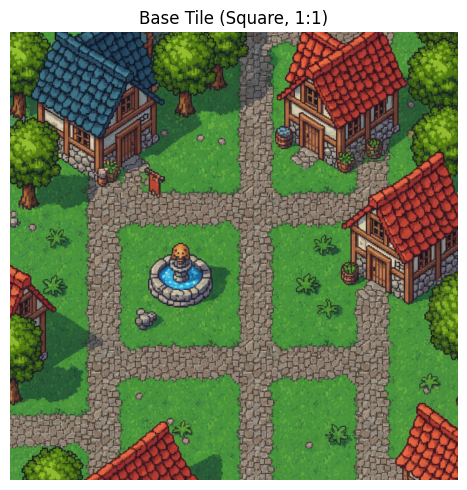


✓ Base tile size: (1024, 1024)


In [9]:
# Generate a starter map tile using the proper prompt
base_prompt = """
Create a **top-down 2D pixel art square game map tile**.

---

### **TECHNICAL SPECS**

* **Tile shape:** Perfect **square** (1:1 aspect ratio).
* **Tile size:** **Large enough that one tile would visually fill a large screen (4096×4096 px)** when viewed at 1:1 scale.
* **Purpose:** Each square tile connects seamlessly in all directions to build an **infinite scrolling map**, generated one tile at a time.
* **Pixel art style:** 16-bit (SNES era).
* **View:** Top-down orthogonal (not isometric).

---

### **STYLE RULES**

* Clean pixel art — **no blur, gradients, or anti-aliasing**.
* **Consistent lighting** from the top-left.
* Use **dithering** for natural texture variation (e.g., grass, dirt, foliage).
* Maintain **high contrast** and readability.
* Avoid placing major features exactly in the center (offset slightly).
* **Simplify edge areas** so neighboring tiles can blend naturally.

---

### **AVOID**

* Frames, borders, or vignettes.
* UI elements, text, or markers.
* Characters or creatures.
* Buildings or cliffs that end abruptly at tile edges.
* Overly symmetrical or perfectly centered focal points.

---

### **INTENT**

The result should look like a **large, square "snapshot"**, a single tile from an **infinite, seamlessly connected world**. Make sure it covers the whole square and no borders. Don't put any separating lines within the tile.

---

### **CONTENT**

Show a fantasy village square with cobblestone paths, grass areas, a small fountain (offset from center), 2-3 buildings with tiled roofs, and trees. Classic RPG style.
"""

print("=== Generating Base Tile ===\n")

base_tile = generate_image(base_prompt, model=MODEL, aspect_ratio=TILE_ASPECT_RATIO)

if base_tile:
    img = save_image(base_tile, "outputs/tile_00_base.png")
    display_images([img], ["Base Tile (Square, 1:1)"])
    print(f"\n✓ Base tile size: {img.size}")

<cell_type>markdown</cell_type>## Test 2: Generate Adjacent Tile (Bottom)

Now let's generate a new square tile that can be placed BELOW the original tile.

This uses the overlap technique:
1. Extract bottom 10% of original tile
2. Place it at top 10% of new square canvas
3. Rest is white
4. Ask Gemini to fill in the white area seamlessly

=== Overlap Setup: Bottom Direction ===

Original tile: 1024x1024 (square)
Overlap slice (bottom 10%): (1024, 102)
New canvas: (1024, 1024) (square)
Overlap region: 102px at top



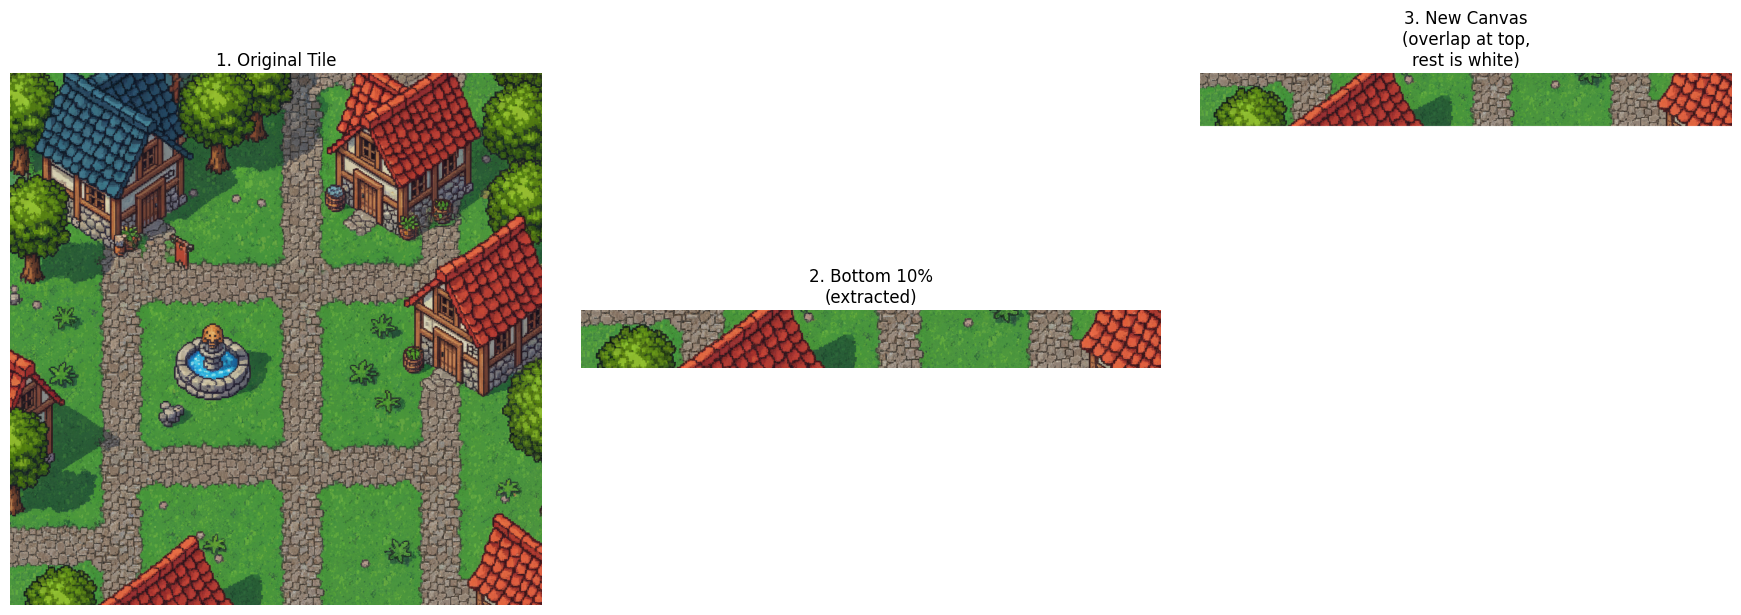

In [10]:
# Visualize the overlap technique for bottom direction
if base_tile:
    original_img = decode_image(base_tile)
    width, height = original_img.size
    
    print("=== Overlap Setup: Bottom Direction ===\n")
    
    # Create the overlap setup
    new_canvas, overlap_slice = create_overlap_outpainting_setup(
        original_img, 
        direction='bottom',
        overlap_fraction=OVERLAP_FRACTION
    )
    
    overlap_px = int(height * OVERLAP_FRACTION)
    
    print(f"Original tile: {width}x{height} (square)")
    print(f"Overlap slice (bottom {int(OVERLAP_FRACTION*100)}%): {overlap_slice.size}")
    print(f"New canvas: {new_canvas.size} (square)")
    print(f"Overlap region: {overlap_px}px at top\n")
    
    # Display the process
    display_images(
        [original_img, overlap_slice, new_canvas], 
        [
            "1. Original Tile", 
            f"2. Bottom {int(OVERLAP_FRACTION*100)}%\n(extracted)", 
            f"3. New Canvas\n(overlap at top,\nrest is white)"
        ],
        figsize=(18, 6)
    )
    
    # Save for visualization
    new_canvas.save("outputs/canvas_bottom_overlap.png")
    overlap_slice.save("outputs/overlap_slice_bottom.png")

In [11]:
# Generate the bottom tile using conversational prompting
if base_tile:
    original_img = decode_image(base_tile)
    
    content_desc = """
Continue the fantasy village theme. You can add:
- More cobblestone paths extending downward
- Additional buildings or natural features (trees, grass)
- Keep the same 16-bit pixel art style
"""
    
    print("\n=== Generating Bottom Tile ===\n")
    
    bottom_tile = outpaint_square_tile(
        original_img,
        direction='bottom',
        content_description=content_desc,
        model=MODEL,
        overlap_fraction=OVERLAP_FRACTION
    )
    
    if bottom_tile:
        print("\n")
        img_bottom = save_image(bottom_tile, "outputs/tile_01_bottom.png")
        
        # Create a visualization showing how they connect
        combined_height = original_img.size[1] + img_bottom.size[1]
        combined = Image.new('RGB', (original_img.size[0], combined_height))
        combined.paste(original_img, (0, 0))
        combined.paste(img_bottom, (0, original_img.size[1]))
        
        combined.save("outputs/tiles_combined_vertical.png")
        
        display_images(
            [original_img, img_bottom, combined], 
            ["Original (Top)", "Generated (Bottom)", "Combined View"],
            figsize=(18, 6)
        )


=== Generating Bottom Tile ===

🎨 Generating new square tile for BOTTOM direction
📐 Canvas size: 1024x1024 (square)


NameError: name 'overlap_size' is not defined

## Test 3: Inpainting - Add/Modify Specific Areas

Test modifying specific regions of the map.

In [ ]:
# Create a mask for a specific region we want to modify
if base_tile:
    original_img = decode_image(base_tile)
    width, height = original_img.size
    
    # Create a circular mask in the center (e.g., to replace the fountain)
    inpaint_mask = create_circular_mask(width, height, width//2, height//2, 100)
    
    display_images([original_img, inpaint_mask], 
                   ["Original", "Inpaint Mask (Center Circle)"])
    
    inpaint_mask.save("outputs/inpaint_mask_center.png")

In [ ]:
# Inpaint to replace the center area using conversational prompting
if base_tile:
    original_img = decode_image(base_tile)
    
    inpaint_description = "replace the fountain with a magical glowing portal or shrine"
    
    print("\n=== Inpainting Center Region ===\n")
    
    modified_tile = inpaint_region(
        original_img,
        prompt_description=inpaint_description,
        model=DEFAULT_MODEL,
        center_circle=(original_img.size[0]//2, original_img.size[1]//2, 100)
    )
    
    if modified_tile:
        print("\n")
        img = save_image(modified_tile, "outputs/map_tile_inpainted.png")
        display_images(
            [original_img, img], 
            ["Original", "Inpainted (Portal Replacement)"]
        )

## Test 4: Multi-Directional Expansion

Test expanding the map in multiple directions to create a larger world.

In [ ]:
def expand_map_tile(base_image_path, direction, prompt_addon=""):
    """Expand a map tile in a specific direction"""
    
    original_img = Image.open(base_image_path) if isinstance(base_image_path, str) else base_image_path
    width, height = original_img.size
    expand_size = 256
    
    # Create extended canvas based on direction
    if direction == 'right':
        new_canvas = Image.new('RGB', (width + expand_size, height), (255, 255, 255))
        new_canvas.paste(original_img, (0, 0))
        mask = create_outpainting_mask(width + expand_size, height, 'right', expand_size)
    elif direction == 'left':
        new_canvas = Image.new('RGB', (width + expand_size, height), (255, 255, 255))
        new_canvas.paste(original_img, (expand_size, 0))
        mask = create_outpainting_mask(width + expand_size, height, 'left', expand_size)
    elif direction == 'top':
        new_canvas = Image.new('RGB', (width, height + expand_size), (255, 255, 255))
        new_canvas.paste(original_img, (0, expand_size))
        mask = create_outpainting_mask(width, height + expand_size, 'top', expand_size)
    elif direction == 'bottom':
        new_canvas = Image.new('RGB', (width, height + expand_size), (255, 255, 255))
        new_canvas.paste(original_img, (0, 0))
        mask = create_outpainting_mask(width, height + expand_size, 'bottom', expand_size)
    
    base_prompt = f"""
    Continue the top-down 2D pixel art RPG map to the {direction}.
    Maintain the same art style, color palette, and seamlessly blend with the existing map.
    {prompt_addon}
    """
    
    # Save temp files
    temp_canvas = f"outputs/temp_canvas_{direction}.png"
    temp_mask = f"outputs/temp_mask_{direction}.png"
    new_canvas.save(temp_canvas)
    mask.save(temp_mask)
    
    result = edit_image_with_mask(temp_canvas, temp_mask, base_prompt)
    
    return result

# Test expanding in different directions
print("Testing multi-directional expansion...")

## Test 5: Generate Different Biome Tiles

Create tiles for different biomes that could be used in an infinite world.

In [ ]:
biome_prompts = {
    "forest": """
        Top-down 2D pixel art RPG map tile of a dense forest.
        Include trees, bushes, a small dirt path winding through.
        Classic 16-bit RPG style with seamless tile edges.
    """,
    "desert": """
        Top-down 2D pixel art RPG map tile of a desert oasis.
        Include sand dunes, cacti, a small pool of water, palm trees.
        Classic 16-bit RPG style with seamless tile edges.
    """,
    "snow": """
        Top-down 2D pixel art RPG map tile of a snowy tundra.
        Include snow-covered ground, pine trees, rocks, ice patches.
        Classic 16-bit RPG style with seamless tile edges.
    """,
    "dungeon": """
        Top-down 2D pixel art RPG map tile of a dungeon interior.
        Include stone floors, walls, torches, treasure chests, traps.
        Classic 16-bit RPG style with seamless tile edges.
    """
}

biome_tiles = {}

for biome_name, prompt in biome_prompts.items():
    print(f"\n=== Generating {biome_name} tile ===")
    tile = generate_image(prompt, aspect_ratio="1:1")
    
    if tile:
        img = save_image(tile, f"outputs/tile_{biome_name}.png")
        biome_tiles[biome_name] = img

# Display all biome tiles
if biome_tiles:
    images = list(biome_tiles.values())
    titles = [name.capitalize() for name in biome_tiles.keys()]
    display_images(images, titles, figsize=(20, 5))

## Test 6: Transition Between Biomes

Test creating smooth transitions between different biome types.

In [ ]:
# Create a transition from forest to desert
if 'forest' in biome_tiles and 'desert' in biome_tiles:
    forest_img = biome_tiles['forest']
    width, height = forest_img.size
    
    # Create canvas with forest on left half
    transition_canvas = Image.new('RGB', (width * 2, height), (255, 255, 255))
    transition_canvas.paste(forest_img, (0, 0))
    
    # Create mask for right half
    mask = create_outpainting_mask(width * 2, height, 'right', width)
    
    transition_canvas.save("outputs/transition_canvas.png")
    mask.save("outputs/transition_mask.png")
    
    transition_prompt = """
    Create a smooth transition from the forest biome on the left to a desert biome on the right.
    The transition should be gradual - start with sparse trees and more sand, 
    then gradually become full desert with cacti and sand dunes.
    Top-down 2D pixel art in classic 16-bit RPG style.
    """
    
    transition_tile = edit_image_with_mask(
        "outputs/transition_canvas.png",
        "outputs/transition_mask.png",
        transition_prompt
    )
    
    if transition_tile:
        img = save_image(transition_tile, "outputs/tile_transition_forest_desert.png")
        display_images([img], ["Forest to Desert Transition"], figsize=(20, 5))

## Test 7: Create a Seamless Tileable Pattern

Generate tiles that can tile infinitely in all directions.

In [ ]:
tileable_prompt = """
Create a seamlessly tileable top-down 2D pixel art RPG ground texture.
Show grass with small flowers and rocks scattered throughout.
The pattern MUST tile perfectly on all four edges (top, bottom, left, right).
Classic 16-bit RPG style, vibrant colors.
When this tile is repeated, there should be no visible seams.
"""

tileable = generate_image(tileable_prompt, aspect_ratio="1:1")

if tileable:
    tile_img = save_image(tileable, "outputs/tileable_grass.png")
    
    # Create a 3x3 grid to show tiling
    width, height = tile_img.size
    tiled_demo = Image.new('RGB', (width * 3, height * 3))
    
    for i in range(3):
        for j in range(3):
            tiled_demo.paste(tile_img, (i * width, j * height))
    
    tiled_demo.save("outputs/tileable_demo_3x3.png")
    display_images([tile_img, tiled_demo], 
                   ["Single Tile", "3x3 Tiled Demo"], 
                   figsize=(15, 8))

## Test 8: Streaming Image Generation

Test streaming to see partial image generation progress.

In [ ]:
def generate_image_streaming(prompt, aspect_ratio="1:1"):
    """Generate image with streaming to see progress"""
    
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json"
    }
    
    payload = {
        "model": MODEL,
        "messages": [{"role": "user", "content": prompt}],
        "modalities": ["image", "text"],
        "image_config": {"aspect_ratio": aspect_ratio},
        "stream": True
    }
    
    print(f"Generating with streaming: {prompt[:80]}...")
    
    response = requests.post(API_URL, headers=headers, json=payload, stream=True)
    
    partial_images = []
    
    for line in response.iter_lines():
        if line:
            line = line.decode('utf-8')
            if line.startswith('data: '):
                data = line[6:]
                if data != '[DONE]':
                    try:
                        chunk = json.loads(data)
                        if chunk.get("choices"):
                            delta = chunk["choices"][0].get("delta", {})
                            if delta.get("images"):
                                for image in delta["images"]:
                                    image_url = image['image_url']['url']
                                    partial_images.append(image_url)
                                    print(f"Received partial image {len(partial_images)}")
                    except json.JSONDecodeError:
                        continue
    
    return partial_images

# Test streaming
stream_prompt = "Top-down 2D pixel art RPG map of a mysterious cave entrance with glowing crystals"
stream_results = generate_image_streaming(stream_prompt)

if stream_results:
    print(f"\nReceived {len(stream_results)} partial images")
    # Display the final image
    final_img = save_image(stream_results[-1], "outputs/streamed_cave.png")
    display_images([final_img], ["Streamed Result"])

<cell_type>markdown</cell_type>## Model Comparison Test

Let's compare GPT-5 Image Mini vs Gemini 2.5 Flash for outpainting quality.

In [ ]:
# Compare both models on the same outpainting task
if base_tile:
    original_img = decode_image(base_tile)
    
    outpaint_description = """
    Continue this top-down 2D pixel art RPG village map.
    Add more village buildings, cobblestone paths, trees, and natural features.
    Classic 16-bit SNES RPG style.
    """
    
    results = {}
    
    print("=== Model Comparison: Outpainting ===\n")
    
    for model_name, model_id in MODELS.items():
        print(f"\n--- Testing {model_name} ({model_id}) ---")
        
        result = outpaint_with_overlap(
            original_img,
            direction='right',
            prompt_description=outpaint_description,
            model=model_id,
            overlap_percent=0.25
        )
        
        if result:
            img = save_image(result, f"outputs/comparison_{model_name}_outpaint.png")
            results[model_name] = img
        
        print()
    
    # Display side by side
    if len(results) > 0:
        images = [original_img] + list(results.values())
        titles = ["Original"] + [f"{name}\nOutpainted" for name in results.keys()]
        display_images(images, titles, figsize=(20, 5))